# Egyptian ID Data Exectraction

## 1-Imports:

In [1]:
# import the necessary packages
#from pyimagesearch.transform import four_point_transform
import numpy as np
import cv2
import imutils
from PIL import Image
import pytesseract
import os
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
from skimage.filters import threshold_otsu

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

## 2-Function to View Images:

In [2]:
def view_imgs(imgs, cols=4, type = 'RGB'):
    """ this function to show a dictionary of imgs using subplot """
    
    rows = np.ceil(len(imgs)/cols)
    width = len(imgs) * imgs[list(imgs)[0]].shape[1]
    height = len(imgs) * imgs[list(imgs)[0]].shape[0]
    figsize = width/100, height/100
    plt.figure(figsize= figsize)
    
    for i, j in enumerate(imgs):
        title = j
        img = imgs[j]
        camp = None
         
        if len(img.shape) < 3:
            camp = 'gray'
        elif type == 'BGR':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(rows, cols, i+1)
        plt.imshow(img,cmap=camp)
        plt.title(title)
        
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

## 3- Order Point Function:

In [3]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
 
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
 
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
 
	# return the ordered coordinates
	return rect

## 4- Four Point Transform Function:

In [4]:
def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
 
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
 
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
 
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
 
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
 
	# return the warped image
	return warped


## 5-Scan ID Function:

In [5]:
def scan_ID(image):
    # load the image and compute the ratio of the old height
    # to the new height, clone it, and resize it 
    ratio = image.shape[0] / 500.0
    orig = image.copy()
    image = imutils.resize(image, height = 500)

    # convert the image to grayscale, blur it, and find edges
    # in the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 0, 60*3)

    # show the original image and the edge detected image
    print("STEP 1: Edge Detection")


    # find the contours in the edged image, keeping only the
    # largest ones, and initialize the screen contour
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

    # loop over the contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            screenCnt = approx
            break
            
    # show the contour (outline) of the piece of paper
    print("STEP 2: Find contours of paper")
    cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
    image_contour=imutils.resize(image, height = 350)


    # apply the four point transform to obtain a top-down
    # view of the original image
    warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
    image_Trasform=imutils.resize(warped, height = 350)

    # convert the warped image to grayscale, then threshold it
    # to give it that 'black and white' paper effect
    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    image_Tgraym=imutils.resize(warped, height = 350)

    val, dst = cv2.threshold(warped,70,255,cv2.THRESH_BINARY)
    orig=imutils.resize(orig, height = 350)
    dst=imutils.resize(dst, height = 350)
    # show the original and scanned images
    print("STEP 3: Apply perspective transform")

    return edged,image_contour,image_Trasform,image_Tgraym,dst


## 6- Extract Text from ID Function:

In [6]:
def extract_Text(warped):
    height,width = warped.shape[:2]
    h = int(height/4) + 5
    w=int(width/4)
    image1=warped.copy()
    strs = ["" for x in range(4)]
    for i in range(1,4):
        if (i==1):
            image = image1[h*i-10:h*(i+1)-15,w:w*4]
            img_name=image.copy()
            text = pytesseract.image_to_string(image,lang='ara')
            strs[i-1] = text

        elif (i==2):
            image = image1[h*i-20:h*(i+1)-25,w-2:w*4]
            img_add=image.copy()
            text = pytesseract.image_to_string(image,lang='ara_combined')
            strs[i-1] = text

        elif (i==3):
            image = image1[h*i-15:h*(i+1)-45,int(w*0.43):w*4]
            img_ID= image.copy()
            text = pytesseract.image_to_string(image,lang='ara_number')
            strs[i-1] = text
    print("Name : " + strs[0])
    print("Address : " + strs[1])
    print("NID : " + strs[2])
    return img_name,img_add,img_ID

## Read Image:

STEP 1: Edge Detection
STEP 2: Find contours of paper
STEP 3: Apply perspective transform


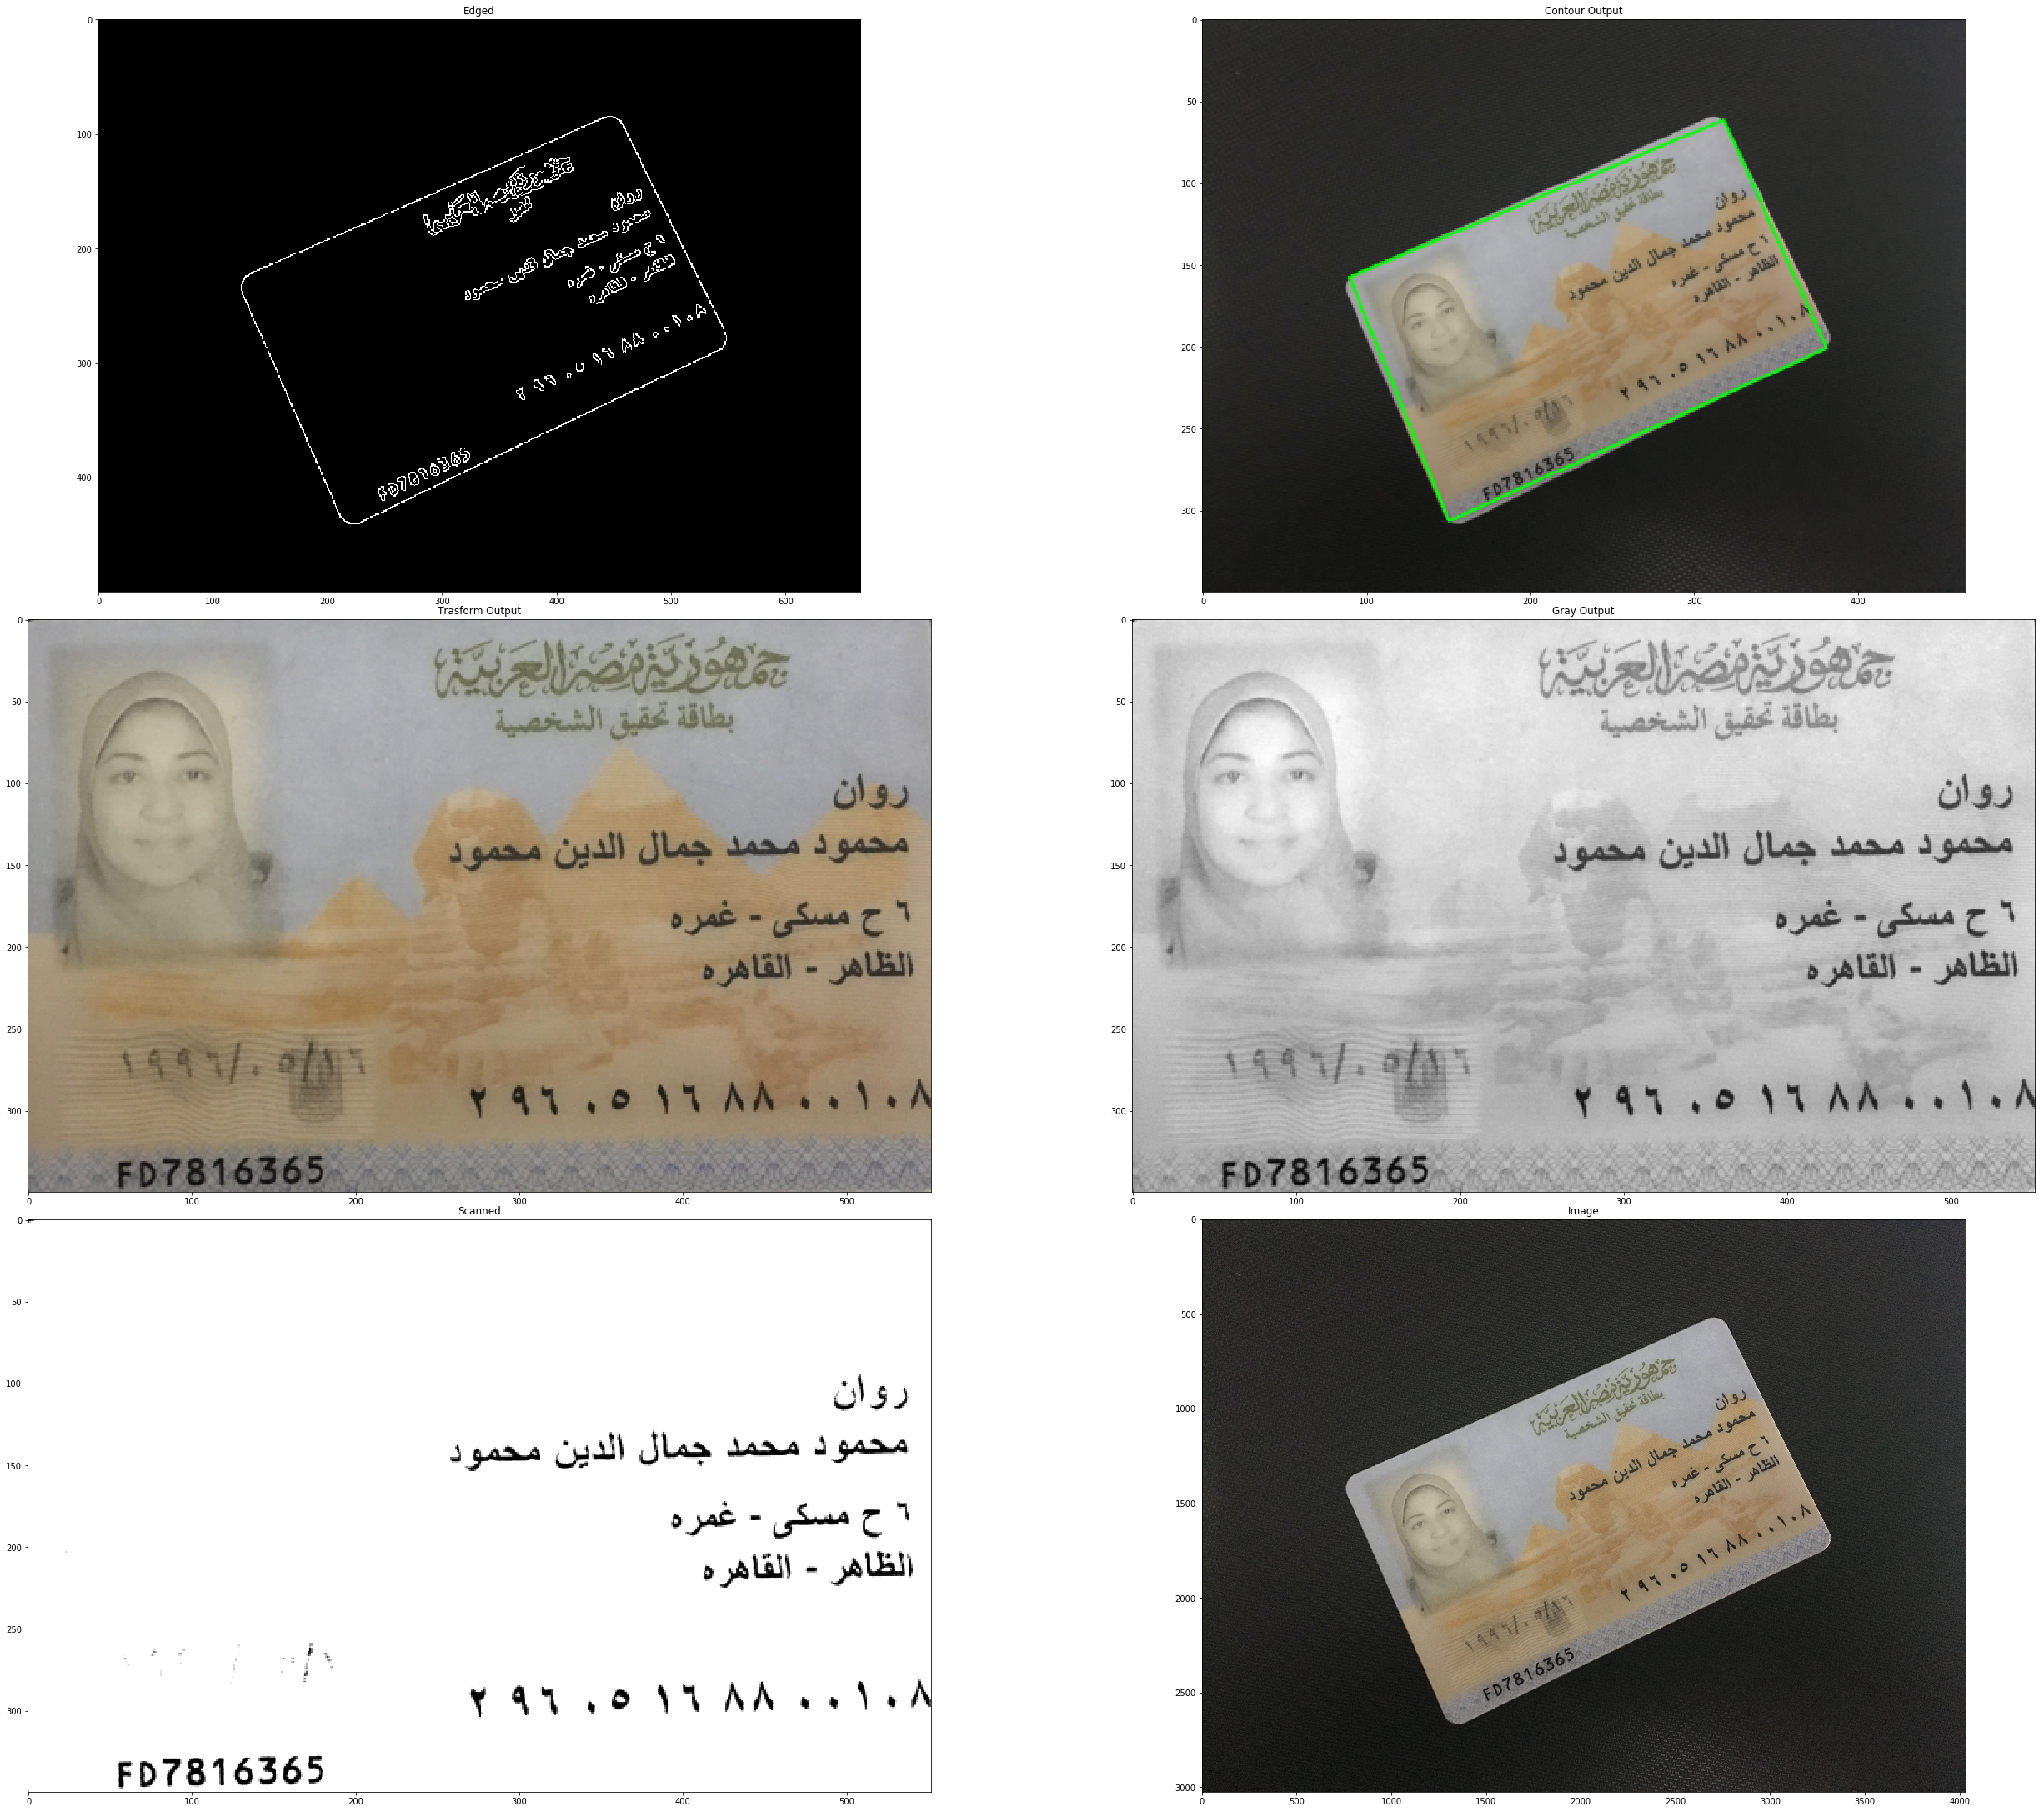

In [7]:
image = cv2.imread("rawan_id8.jpg")
edged,image_contour,image_Trasform,image_Tgraym,dst= scan_ID(image)
img_dict={"Image":image,"Edged":edged,"Contour Output":image_contour,"Trasform Output":image_Trasform,"Gray Output":image_Tgraym,"Scanned":dst}
view_imgs(img_dict, 2, type ='BGR')

## Extract Text:

Name : روان
محمود محمد جمال الدين محمود
Address : ٦ح‏ مسکی - غمره
الظاهر - القاهره
NID : 29605168800108


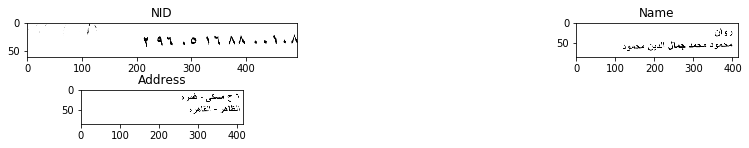

In [8]:
img_name,img_add,img_ID=extract_Text(dst)
img_dict={"Name":img_name,"Address":img_add,"NID":img_ID}
view_imgs(img_dict, 2, type ='BGR')